# Data Analysis in Geoscience Remote Sensing Projects: Exercises
## Final task handed in by: SATVIK PARASHAR, on 12/04/2024
Hendrik Andersen, contact: hendrik.andersen@kit.edu

## Part one: Regression and sensitivity estimation with remote sensing data

For this part you are provided with a data set contained in the file 'data_final_task_regression.csv'. The data contains information on regional averages of low-cloud occurrence and meteorological factors in the Southeast Atlantic (10°S-20°S, 0°E-10°E - this means that the study area is about 1000 km x 1000 km large). The DataFrame contains the following variables:
- sst: sea surface temperature
- eis: estimated inversion strength
- t_adv: temperature advection
- w700: vertical pressure velocity at 700 hPa (this is the vertical wind speed, given in Pa/s: positive numbers mean subsiding air masses)
- rhft: relative humidity in the free troposphere (free troposphere is above the cloud layer)
- clf: Liquid water cloud fraction

The data on clouds are from a satellite data set from the MODIS sensor on board NASA's Terra satellite. The product name is MOD08_M3, downloaded from https://ladsweb.modaps.eosdis.nasa.gov/ for more information check out https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/MOD08_M3/#overview

The meteorological data are ERA5 reanalysis data on meteorological factors thought to be important for low cloud cover. The data is downloaded from https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview

For more information on how reanalysis data are generated, check out the 2-minute video from Copernicus ECMWF here: https://www.youtube.com/watch?v=FAGobvUGl24

Your task is to analyze the data to
1. quantitatively and visually describe the data 
2. analyze relationships between cloud fraction and the cloud-controlling factors using
    - regression analysis
    - a machine learning model (e.g. feature importance, SHAP)
3. describe the results of your analyses in the provided markdown cells. Are your results in agreement with the described relationships in the following study?: Klein et al. (2017): Low-Cloud Feedbacks from Cloud-Controlling Factors: A Review, Surveys in Geophysics, doi: 10.1007/s10712-017-9433-3




In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.datasets import fetch_openml
from datetime import datetime, timedelta
from scipy.stats import pearsonr, linregress
import csv

In [2]:
# load dataset

df = pd.read_csv("data_final_task_regression.csv", index_col='time', parse_dates=True)
df.head()

,sst,eis,t_adv,w700,rhft,clf
time,,,,,,
2001-01-01,296.16850,4.824931,-1.682254,0.022467,35.642094,0.663396
2001-02-01,297.11526,3.476827,-1.932790,0.026573,37.940147,0.605880
2001-03-01,298.15900,2.265783,-2.199120,0.031560,33.834457,0.529290
2001-04-01,298.17062,2.402812,-2.532412,0.039651,21.565330,0.464151
2001-05-01,297.06927,3.534788,-2.962148,0.037318,7.997189,0.318764


## Part one: Regression and sensitivity estimation with remote sensing data
__Task__: 
In a typical scientific workflow, the first step is to get an overview of the data. Typically, visualizations and descriptive statistics are very useful to achieve this.  
1. Calculate the mean and standard deviation of cloud fraction and plot the distribution of cloud fraction in a histogram.
2. Plot the CLF time series and describe seasonal patterns.

1.1a) About the Dataset and Statistics

In [3]:
print("The file contains monthly data on cloud cover and other meteorological factors from", df.index.min(), "to", df.index.max())

The file contains monthly data on cloud cover and other meteorological factors from 2001-01-01 00:00:00 to 2020-12-01 00:00:00


mean cloud fraction is 0.6522455561224002
standard deviation of cloud fraction is 0.15502950170701116


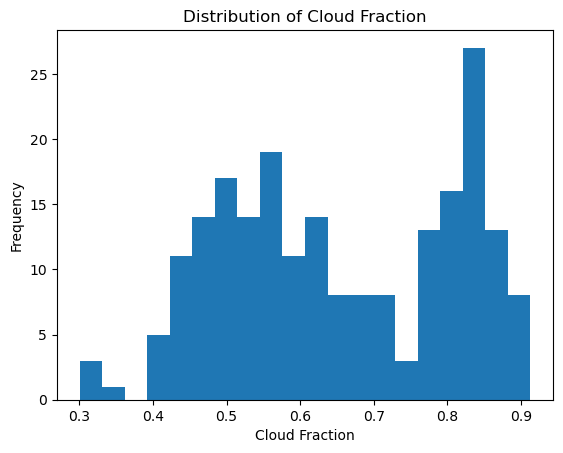

In [4]:
# Calculate the mean and standard deviation of cloud fraction
mean_cloud_frac = np.mean(df['clf'])
std_cloud_frac = np.std(df['clf'])

print(f'mean cloud fraction is {mean_cloud_frac}')
print(f'standard deviation of cloud fraction is {std_cloud_frac}')

plt.hist(df['clf'], bins=20)
plt.xlabel('Cloud Fraction')
plt.ylabel('Frequency')
plt.title('Distribution of Cloud Fraction')
plt.show()

The data is not symmetric around the mean value (0.65), therefore does not follow a normal distribution and is skewed to the right. The mean shifts to the right as there are some time periods (since it is time series data) with very high cloud fraction (bw 0.8 - 0.9). 

1.1b) Decomposing Time Series

In [5]:

#Time series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

ts_decomp = seasonal_decompose(df['clf'], model='additive', period=12)#,extrapolate_trend='freq')#period = 12) # we set the cyclic period of the seasonal cycle by hand
trend_estimate = ts_decomp.trend
seasonal_estimate = ts_decomp.seasonal
residual_estimate = ts_decomp.resid

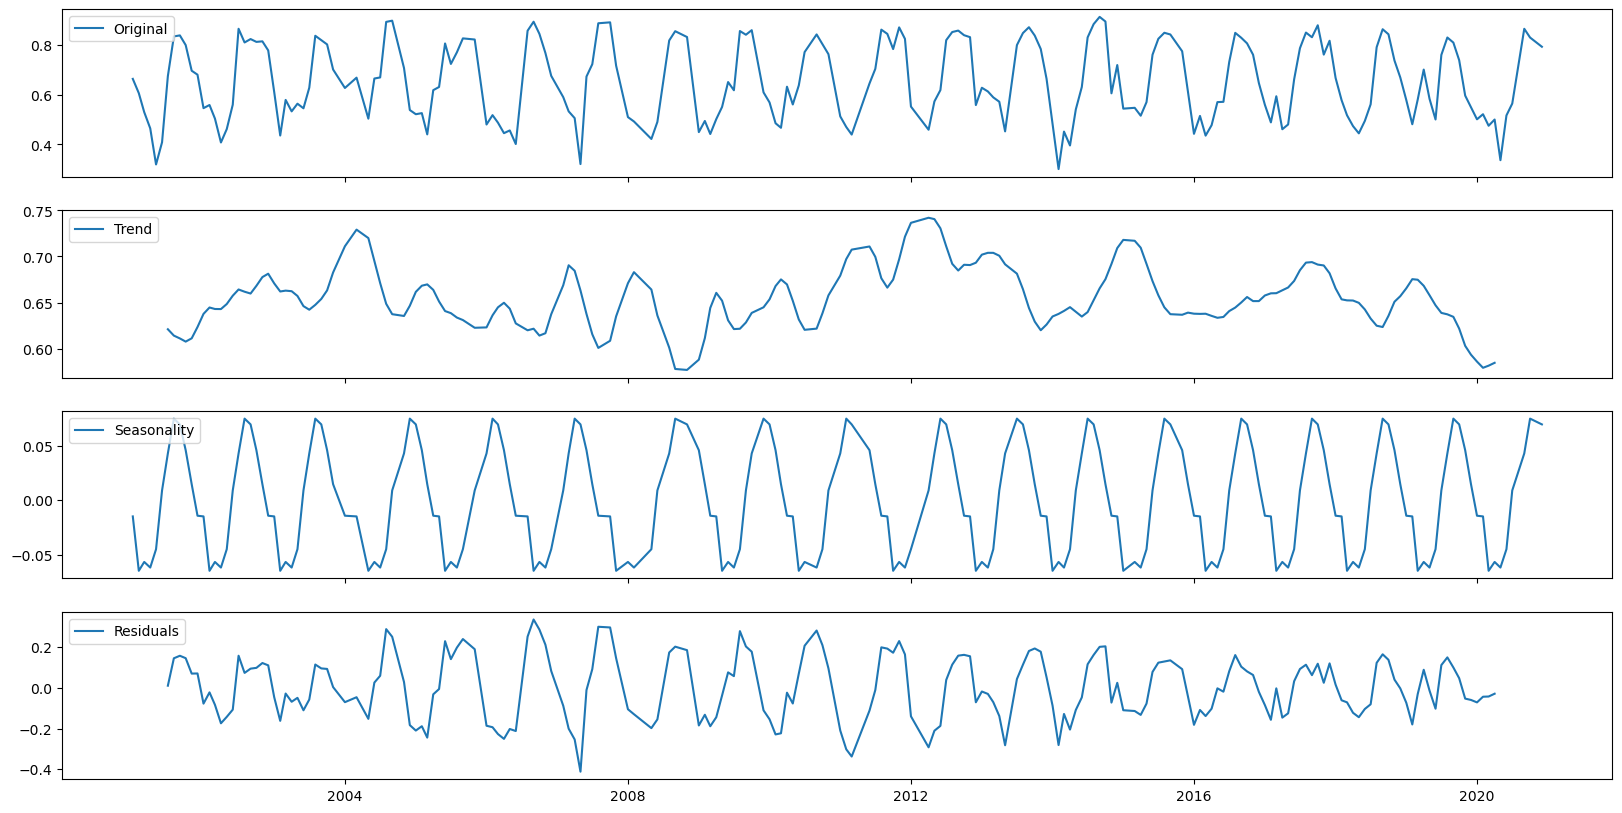

In [6]:
# Plotting the time series and its individual components together
fig, ax = plt.subplots(4, 1, sharex=True, sharey=False)
#fig, ax = plt.subplots(5, 1, sharex=True, sharey=False)

fig.set_figheight(10)
fig.set_figwidth(20)

ax[0].plot(df['clf'], label='Original') 
ax[0].legend(loc='upper left')

ax[1].plot(trend_estimate, label='Trend')
ax[1].legend(loc='upper left')

ax[2].plot(seasonal_estimate, label='Seasonality')
ax[2].legend(loc='upper left')

ax[3].plot(residual_estimate, label='Residuals')
ax[3].legend(loc='upper left')



As we see in above plot, the data has no specific trend, just an annual seasonality. 
Lets zoom in to the data observe the seasonality more closely

<class 'pandas.core.series.Series'>


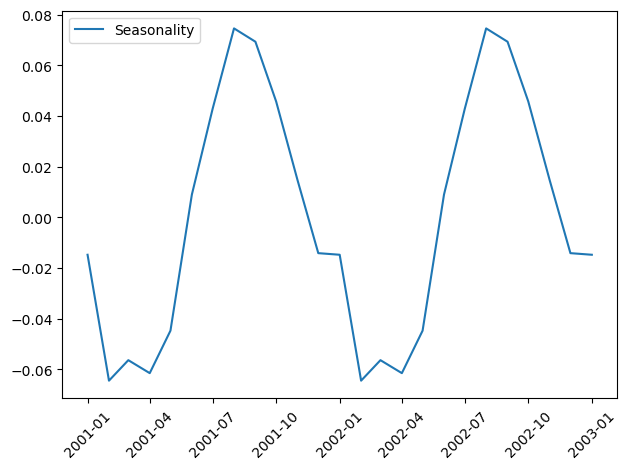

In [7]:
#zooming in to see the seasonality across first 2 years
print(type(seasonal_estimate))
#clipping timeseries
seasonal_2yrs = seasonal_estimate['2001-01-01':'2003-01-01']

fig, ax = plt.subplots()
ax.plot(seasonal_2yrs, label='Seasonality')
ax.legend(loc='upper left');

plt.xticks(rotation=45)  # Rotating x ticks to avoid overlap
plt.tight_layout()
plt.show()

After observing the seasonality of the data, it is evident that:
- The cloud cover is lowest from somehere between January and end March.
- April onwards the cloud cover steadily increases and peaks around mid july and then steadily decreases till January

__Task__: 
1. Compute a regression analysis of CLF with each meteorological predictor
2. Describe the sensitivities of CLF to the meteorological predictors:
    - How sensitive are low clouds to changes in meteorological predictors (in individual simple regression models, and in a multiple regression framework)?
    - Are the relationships significant?
    - Are there strong correlations between the different predictors that could influence the sensitivity estimates?
  
For the multiple linear regression, you want to be able to compare the sensitivity estimates of the different predictors (to see which ones are most important). To do this, the predictors need to be on the same scale. This is done in the code cell below by using the standard scaler (it subtracts the mean and divides by a standard deviation, so that all predictors in X have a mean value of 0 and unit variance).

1.2.1) Regression Analyses with Each Variable Individually

In [8]:
# defining input and output

X = df[['sst','eis','t_adv','w700','rhft']] #all the input controlling factors
y = df['clf'] #output cloud fraction

#from sklearn.model_selection import train_test_split #only needed for part2
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)



RMSE for sst: 0.07138638194576154
Linear regression for sst: y = 19.06647381855303 + [-0.06236668] * x


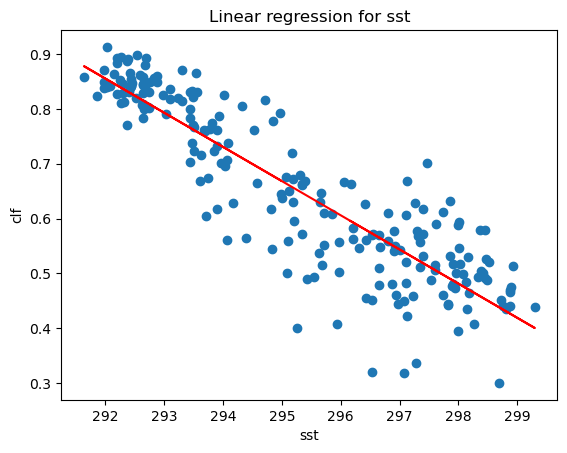

RMSE for eis: 0.06634079864114807
Linear regression for eis: y = 0.30691456629112734 + [0.05985523] * x


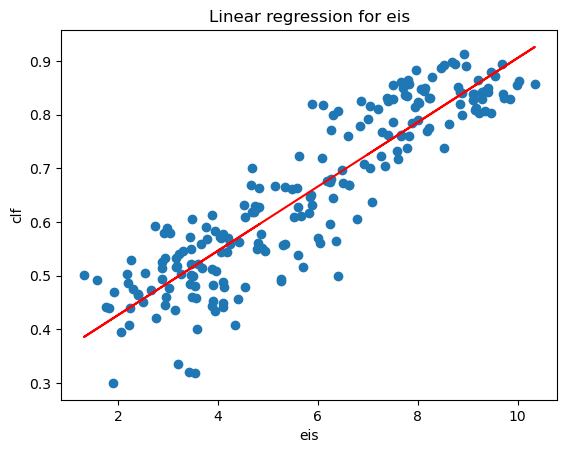

RMSE for t_adv: 0.15283923177227282
Linear regression for t_adv: y = 0.5286827391106106 + [-0.0466359] * x


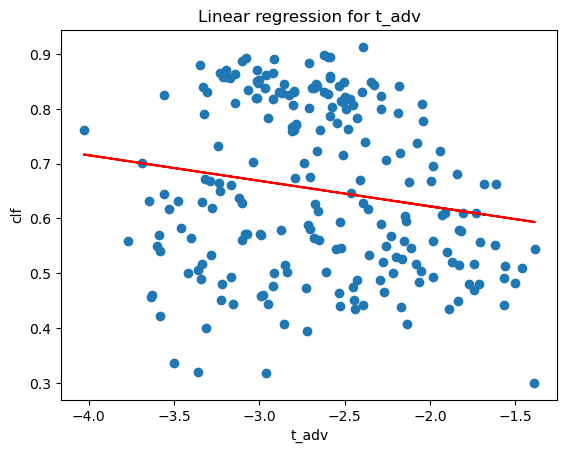

RMSE for w700: 0.15501028417150609
Linear regression for w700: y = 0.6406299982260678 + [0.33363669] * x


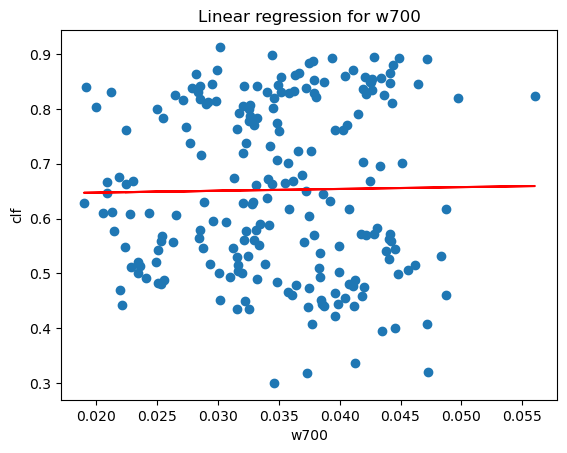

RMSE for rhft: 0.15466260071302684
Linear regression for rhft: y = 0.6756049091303078 + [-0.00109281] * x


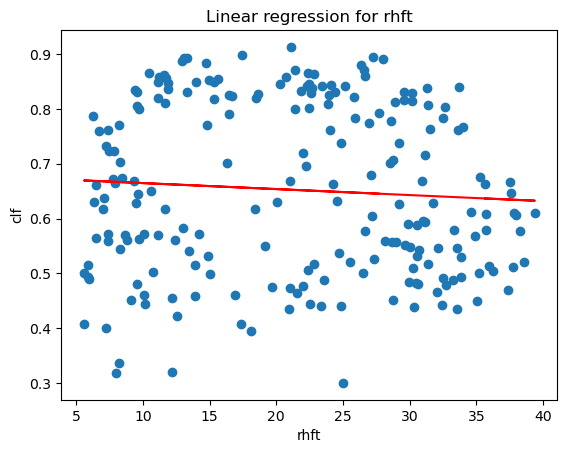

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Perform linear regression on each input column individually
for col in X:

    X_ = np.expand_dims(X[col].values, axis = 1) # expand dimensions of X for LinearRegression() (as done in chapter 3)
    lr = LinearRegression()
    lr.fit(X_, y) # fitting the regression model
    y_pred = lr.predict(X_) # use the trained linear model to predict a value for each of the values in X_
    #calculating mean squared error for each variable
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    #print rmse for each column
    print(f"RMSE for {col}: {rmse}")
    #intercept_ and slope_ parameters of the LinearRegression() function gives the last intercept and slope value in the loop 
    print(f"Linear regression for {col}: y = {lr.intercept_} + {lr.coef_} * x") 
    # Plot the data and the regression line
#for col in X_train: #have to do the plotting in same for loop to avoid error
    plt.scatter(X[col], y)
    plt.plot(X[col], lr.predict(X_), color='red')
    plt.title(f"Linear regression for {col}")
    plt.xlabel(col)
    plt.ylabel('clf')
    plt.show()

As we can see the RMSE is least for sst and eis (bw 6% and 7%). The regression line also best fits the data for these two factors. Other factors have relatively high rmse (around 15%). This indicates that, among the given factors, sst and eis most accurately predict cloud fraction.

1.2.2) Multiple Regression and Sensistivity Estimation

Multiple linear regression: y =  0.6522455561223979
 + -0.08376939423730859 * sst
 + 0.062361632694373934 * eis
 + -0.013258436019865791 * t_adv
 + 0.006391793703540369 * w700
 + 0.03345952562851684 * rhft


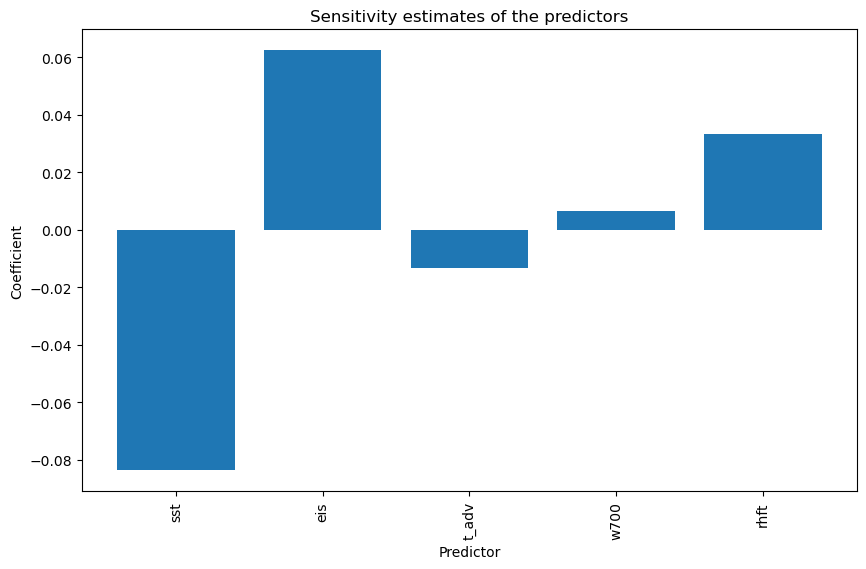

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Preprocessing: standardizing the predictors using the given code
X = df.drop(['clf'], axis=1)
y = df.clf
X_standardized = StandardScaler().fit(X).transform(X)

# Perform multiple linear regression
mlr = LinearRegression()
mlr.fit(X_standardized, y)

# Print the intercept and coefficients in the same way as done for individual linea regression
print("Multiple linear regression: y = ", mlr.intercept_)
for i, col in enumerate(X.columns):
    print(f" + {mlr.coef_[i]} * {col}")

# Ploting the coefficients to visualise sensitivity estimates
coefs = mlr.coef_
names = X.columns
plt.figure(figsize=(10, 6))
plt.bar(names, coefs)
plt.xticks(rotation=90)
plt.title("Sensitivity estimates of the predictors")
plt.xlabel("Predictor")
plt.ylabel("Coefficient")
plt.show()

Sensitivity estimate is the degree by which each factor influences the cloud fraction, measured by their indivudal slopes. sea surface temperature (sst) and estimated inversion strength (eis) has the highest influence on cloud fraction.

Lets compute a correlation matrix to quantify the relationship between all the factors

In [11]:
#computing correlation
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,sst,eis,t_adv,w700,rhft,clf
sst,1.000000,-0.952528,0.234236,-0.105163,0.278919,-0.887675
eis,-0.952528,1.000000,-0.185520,0.001725,-0.134703,0.903815
t_adv,0.234236,-0.185520,1.000000,-0.507787,0.649370,-0.167501
w700,-0.105163,0.001725,-0.507787,1.000000,-0.585793,0.015745
rhft,0.278919,-0.134703,0.649370,-0.585793,1.000000,-0.068758
clf,-0.887675,0.903815,-0.167501,0.015745,-0.068758,1.000000


We can see that that clf has weak correlation with t_adv0.16), w700(0.016), and rhft(-0.07) with . While it has strong correlation with sst(-0.89) and eis(0.9). 
eis and sst themselves have very strong negative correlation with each other. Therefore either of these could replace one another in case we need to do a dimensionality reduction.

__Task__:
Use a machine learning model to 
1. Predict CLF as accurately as possible [low validation error (e.g. MSE or RMSE) and high explained variance (R²), tuning of hyperparameters]
2. Plot a scatter plot of observed CLF vs. model predicted CLF for the both training and test data sets to visualize model performance and check for overfitting. Do the same for a multiple linear regression model, is the machine learning model better than the multiple regression?
3. Which predictors are most important for the model to predict CLF? [feature importance]
3. Analyze the two most important meteorological features in more detail: How do they influence the prediction of CLF? [partial dependency, SHAP] 

1.3)

In [14]:
#splitting data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) #ensure that X and y are defined previously

1.3 1&2) Predict CLF using Multiple Linear Regression (MLR) and Evaluate Model Performance

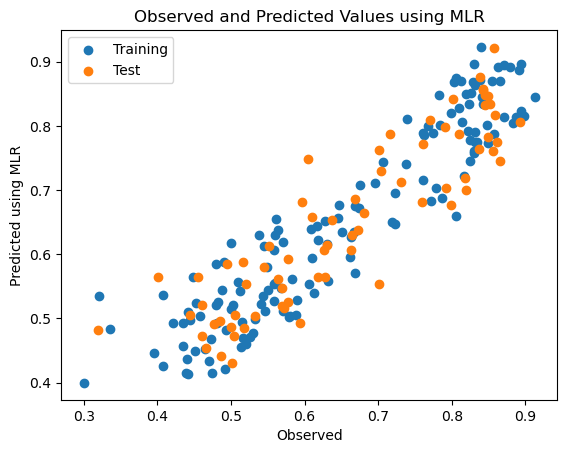

In [15]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(X_train, y_train)

# Plot observed vs. predicted for training data
plt.scatter(y_train, mlr.predict(X_train), label='Training')

# Plot observed vs. predicted for test data
plt.scatter(y_test, mlr.predict(X_test), label='Test')

# Add labels and legend
plt.xlabel('Observed')
plt.ylabel('Predicted using MLR')
plt.title("Observed and Predicted Values using MLR")
plt.legend()
plt.show()


Evaluating Accuracy of MLR

In [19]:
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, f1_score
#Accuracy Assessment by comparing the model generated independent test data
y_pred_test = mlr.predict(X_test)
# Calculate accuracy
r2 = r2_score(y_test, y_pred_test)
print(f"R-Squared MLR: {r2}")
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE MLR: {rmse}")

R-Squared MLR: 0.7967960995502942
RMSE MLR: 0.06620122971832584


1.3 1&2) Implementing Gradient Boosting Regression Trees (GBRT).

In [20]:
#implement gbrt

from sklearn.ensemble import GradientBoostingRegressor

# assign the function to a variable name and train the model by calling the method model.fit() 
gbrt_model = GradientBoostingRegressor() # by not defining them here, we keep all GradientBoostingRegressor hyperparameters at the default values 
gbrt_model.fit(X_train, y_train) # we see the convenience of having the same syntax for all models in sklearn here

y_pred_gbrt_train = gbrt_model.predict(X_train)
y_pred_gbrt_test = gbrt_model.predict(X_test)


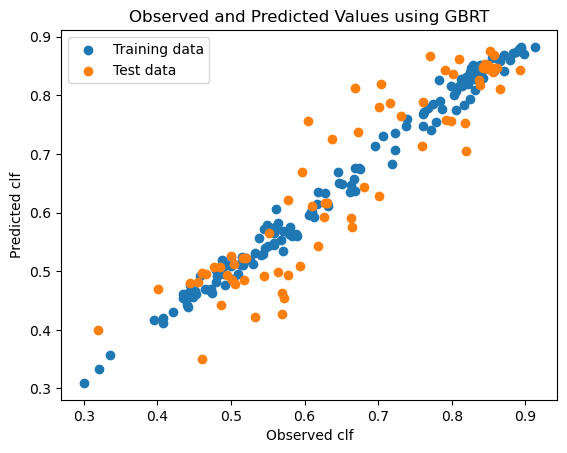

In [21]:
# Plot the training and Test data
plt.scatter(y_train, y_pred_gbrt_train, label='Training data')
plt.scatter(y_test, y_pred_gbrt_test, label='Test data')

# Add labels and title
plt.xlabel('Observed clf')
plt.ylabel('Predicted clf')
plt.title('GBRT Scatter plot of observed vs. predicted clf')
plt.title("Observed and Predicted Values using GBRT")
plt.legend()

# Show the plot
plt.show()

Evaluating Gradient Boosting Regression Trees (GBRT)

In [22]:

# Calculate R-squared
r2 = r2_score(y_test, y_pred_gbrt_test)
print(f"R-squared GBRT: {r2}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbrt_test))
print(f"RMSE GBRT: {rmse}")

R-squared GBRT: 0.8202329913891014
RMSE GBRT: 0.0622665828583192


r2 score with GBRT (~0.82) is higher than that with linear regression (~0.79). The score can further be improved by finding the best hyperparameter combination of the GBRT model.

In [23]:
#I couldn't resolve the following error in hyperparameter tuning code - "OverflowError: Python int too large to convert to C long"

# from sklearn.model_selection import RandomizedSearchCV
# n_iter = 100 # number of random iterations
# # here, we define the way the values for the RandomizedSearchCV are drawn for each specific hyperparameter that we want to tune
# random_params = {'learning_rate': np.random.uniform(0,1,size = n_iter),
#         'max_depth': np.random.randint(3, 10, n_iter),
#         'n_estimators': np.random.randint(100, 500, n_iter),
#         'subsample':np.random.uniform(0,1,size = n_iter),
#         'min_samples_split': np.random.randint(3, 30, n_iter)
#          }

# # assign the function RandomizedSearchCV to a variable name and train the models in using hyperparameters set in the variable random by calling the method model.fit() 
# searchcv = RandomizedSearchCV(gbrt_model, random_params, n_iter = n_iter, n_jobs = -1, verbose = 1, cv = 5)
# searchcv.fit(X_train, y_train) # now get a coffee - this may take a while (~16 minutes on my laptop)
# # one attribute of RandomizedSearchCV is "best_estimator_", which is the model instance with the combination of hyperparameter values that produced the best results in the cross validation 
# best_gbrt_model = searchcv.best_estimator_

1.3.3) Feature Importance

In [24]:
#Feature Importance
df_feature_importance=pd.DataFrame(gbrt_model.feature_importances_,index=X.columns,columns=["Feature Score"])
#sort values in descending order
df_feature_importance.sort_values(by="Feature Score",ascending=False,inplace=True)
df_feature_importance

,Feature Score
eis,0.802174
sst,0.113558
rhft,0.043518
t_adv,0.024643
w700,0.016107


eis and sst have the highest feature score. Therefore, they can be considered the most important factors in determining cloud fraction

1.3.4) SHAP Feature Values

In [25]:

import shap
explainer = shap.TreeExplainer(gbrt_model) # using the more accurate gbrt model as input here
shap_values = explainer.shap_values(X_test)
#np.shape(shap_values)#.values)

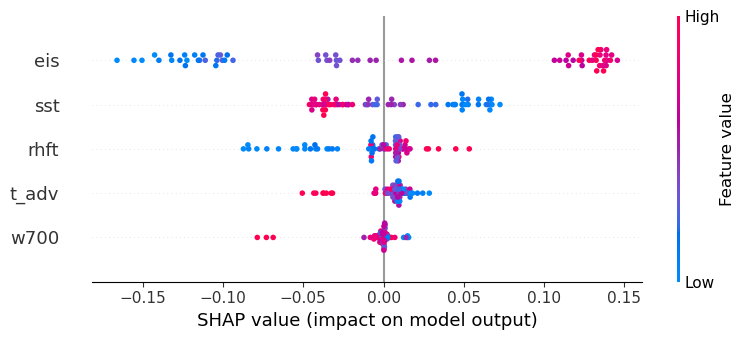

<Figure size 640x480 with 0 Axes>

In [26]:
#shap plot
shap.summary_plot(shap_values,X_test)
plt.savefig("shap_beeswarm_summary.png")

SHAP (SHapely Additive ExPlanations) is used to draw out some explanation of results from otherwise 'blackbox' machine learning models. It helps us identify the contribution of each feature in predicting each output.
The higher the magnitude of shap values, the more contribution a particular feature has on the particular model output.
This implies that:
- eis values followed by sst values influence the cloud fraction to a very high degree
- Higher clf values are observed when there are highest eis values (red points) and lowest sst values (blue points). This confirms our previous correlation matrix that shows clf's strong positive correlation with eis and strong negative correlation with sst.

Klein et al. (2017) findings (Table 1) also confirm that more clouds are formed as a result of lower eis, higher sst, higher t_adv, higher w700, and higher humidity. Therefore, the regression results corraborate with the given study.

## Part two: Classification in a remote sensing retrieval setting

__Task__
1. Divide data into test and training data sets
2. Train and optimize (hyperparameter tuning) a machine learning model 
3. Train a logistic regression model
4. Analyze both classifiers with a confusion matrix and perfomance metrics

In [27]:
#import packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.datasets import fetch_openml
from datetime import datetime, timedelta
from scipy.stats import pearsonr, linregress
import csv

In [28]:
import xarray as xr

data = xr.open_dataset('data_final_task_classification.nc') # load the data set
X = data[['IR_016','IR_039','IR_087','IR_097','IR_108','IR_120','IR_134']] # define X to be the satellite observations from different channels
X['hour'] = data.time['time.hour'] # use the hour of the observation as an additional predictor
X = X.to_dataframe() # convert to a pandas data frame

y = data.station_fls # define y to be the True/False labels from the meteorological station

# continue your code here
X.head()
y.head()

<xarray.DataArray 'station_fls' (time: 5)>
[5 values with dtype=bool]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01T02:15:00 ... 2017-01-01T03:30:00

2.1) Data Splitting into Training and Test

In [29]:
#split the data into training and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=0)
print(X_train.shape)
print(X_test.shape)

(6844, 8)
(3371, 8)


2.2a) Implementing and Evaluating Gradient Boosting Classifier

In [30]:
#implementing gradient boosting classification (from - https://www.youtube.com/watch?v=Imgh1tTFe1w&ab_channel=MazenAhmed)
from sklearn.ensemble import GradientBoostingClassifier
gb_clas = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=0)
gb_clas = gb_clas.fit(X_train,y_train)

#generating prediction
y_pred=gb_clas.predict(X_test)

#confusion matrix (CM)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
CM_gb = confusion_matrix(y_test, y_pred)
print(CM_gb)

[[1685  257]
 [ 473  956]]


In [31]:
#Evaluating GB Classifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy GB Clas.:", accuracy)

# # Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision  GB Clas.:", precision)

# # Calculate recall (sensitivity)
# recall = recall_score(y_test, y_pred)
# print("Recall (Sensitivity) GB Clas.:", recall)

# Calculate F1-score - As it takes into account both precision and recall
f1 = f1_score(y_test, y_pred)
print("F1-Score: GB Clas.", f1)
#from evaluation of gradient boosting classification model( https://medium.com/@maxgrossman10/accuracy-recall-precision-f1-score-with-python-4f2ee97e0d6)


Accuracy GB Clas.: 0.7834470483536042
F1-Score: GB Clas. 0.7236941710825133


The GB Classifier without tuning gives an overall accuracy of ~78% and an F1-Score of ~72%. 

Lets try hyperparameter tuning to see if it performs better. We will use Randomized Search to optimise model performance with random parameter combinations, as it is compuationally more efficient than full Grid Search.

2.2b) Optimise GB Classifier using Randomized Search Hyperparamter Tuning

In [32]:
# Import necessary libraries
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define a dictionary with parameters values for gradient boosting classification
param_dist = {
	'n_estimators': np.arange(50, 251, 50),
	'learning_rate': np.linspace(0.01, 0.2, 10),
	'max_depth': np.arange(3, 8),
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, n_iter=10,
								cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

# Fit the model to the training data using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_best_random = best_model_random.predict(X_test)

# Evaluate the best model
accuracy_best_random = accuracy_score(y_test, y_pred_best_random)

# Print the results
print("Randomized CV gives the following best parameters combination:", best_params_random)
#print(f"Best Model Accuracy (Randomized Search): {accuracy_best_random}")


#tuning of gb classifier: (from https://www.geeksforgeeks.org/how-to-tune-hyperparameters-in-gradient-boosting-algorithm/)

Randomized CV gives the following best parameters combination: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1577777777777778}


In [33]:
#confusion matrix (CM)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
CM_best_gb = confusion_matrix(y_test, y_pred_best_random)
print(CM_best_gb)

#Evaluating BEST GB Classifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_best_random)
print("Accuracy BEST GB Clas.:", accuracy)

# Calculate F1-score - As it takes into account both precision and recall
f1 = f1_score(y_test, y_pred_best_random)
print("F1-Score: BEST GB Clas.", f1)
#from evaluation of gradient boosting classification model( https://medium.com/@maxgrossman10/accuracy-recall-precision-f1-score-with-python-4f2ee97e0d6)


[[1709  233]
 [ 373 1056]]
Accuracy BEST GB Clas.: 0.8202313853455948
F1-Score: BEST GB Clas. 0.7770419426048565


After tuning the parameters, the overall accuracy increased to ~83% and the F1 score increased to ~0.79%. 
- There is a noticable increase in the accuracy of the classifier
- It is a good idea to tune parameters of an ML model using Randomized Search. It is a good balance between accuracy and computing time, at gives more accuracy than the untuned model and takes less computational time than a full grid search.

2.3) Logistic Regression Classifier

In [36]:
# Logistic Regression
#we define the classifier to be a logistic regression 
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(random_state = 0)
logr.fit(X_train, y_train) # ... and fit the model on the training data
y_pred_logr = logr.predict(X_test) # we can make predictions on the test data

#To analyse the performance we can use a confusion matrix (see lecture slides)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
CM_lr = confusion_matrix(y_test, y_pred_logr)
print(CM_lr) 

[[1576  366]
 [ 714  715]]


D:\Software_Installed\Anaconda\envs\my_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
#evaluation of Logistic Regression model(https://medium.com/@maxgrossman10/accuracy-recall-precision-f1-score-with-python-4f2ee97e0d6)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_logr)
print("Accuracy Logistic Regresssion:", accuracy)

# Calculate F1-score
f1 = f1_score(y_test, y_pred_logr)
print("F1-Score Logistic Regression:", f1)


Accuracy Logistic Regresssion: 0.6796202907149214
F1-Score Logistic Regression: 0.5697211155378487


Logitic Regression gives much lower score (overall accuracy ~68% and F1-Score ~57%) than even the Untuned GB Classifier

2.4) Comparing Confusion Matrix of Each Classifier

Text(0.5, 1.0, 'Best GB Classification')

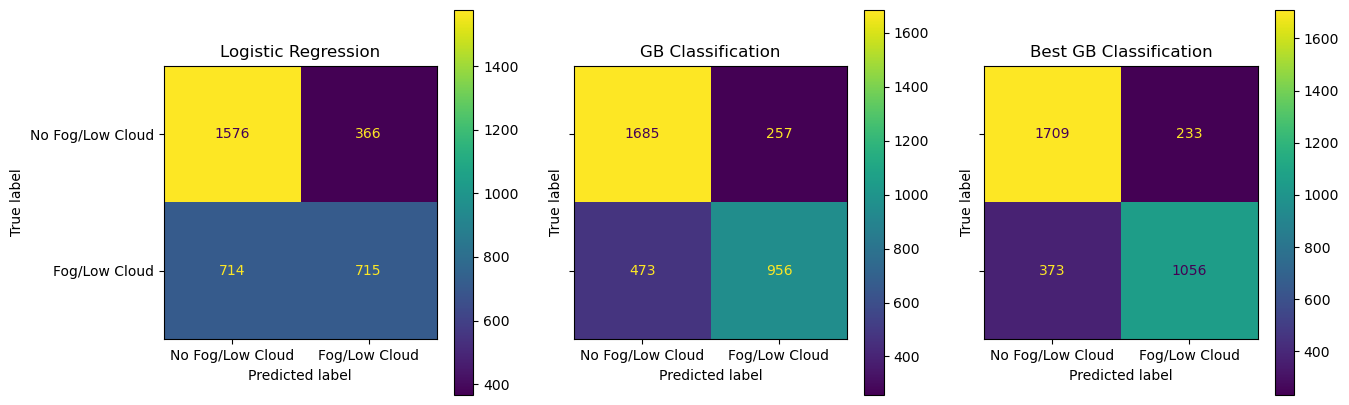

In [38]:
# Creating parallel subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey = True)

# Plotting confusion matrices
disp_lr = ConfusionMatrixDisplay(CM_lr, display_labels=['No Fog/Low Cloud', 'Fog/Low Cloud'])
disp_lr.plot(ax=axs[0])
axs[0].set_title("Logistic Regression")

disp_gb = ConfusionMatrixDisplay(CM_gb, display_labels=['No Fog/Low Cloud', 'Fog/Low Cloud'])
disp_gb.plot(ax=axs[1])
axs[1].set_title("GB Classification")

disp_best_gb = ConfusionMatrixDisplay(CM_best_gb, display_labels=['No Fog/Low Cloud', 'Fog/Low Cloud'])
disp_best_gb.plot(ax=axs[2])
axs[2].set_title("Best GB Classification")


Gradient Boosting Classifier, even without tuning (middle plot), has much higher prediction accuracy than Logistic Regression (leftmost plot). GB Classification with hyperparameter tuning (rightmost plot) gives the best results.
This signifies the importance of an ensemble learning (here boosting) along with parameter tuning for increasing prediction accuracy.

Results Comparison with Henderson et. al., 2018:

- The prediction accuracy of the algorithm used in the study (94%) is much higher than even the tuned GB classifier. In addition to the initial classification, the study makes use of contextual information using the pixel neigbourhood.
- The study makes use of the structural similarity index (SSIM). In this approach a pixel's 8 neigbouring pixels are also taken into account for its classification. It iteratively assigns the pixel 'difficult' to classify as FLC, starting the iteration if 5 of the neigbouting 8 pixels belong to a different class, and increasing until no further changes are possible.
- It is stated in the study that the classification alone using measurement on thermal infrared wavelength (8-15 microns (µm)) does not do a great job in seperating FLCs from land surface. Hence, it is likely that our classification approach must have confused FLC with other classes

The algorithm used in the study make  use of SSIM approach along with classification. This must have further seperated FLCs with Land Surface/ High cloud classes. This could be a possible reason for higher accuracy in the study than the above classification algorithmsion 

References

- Decomposing time series data. (n.d.). Retrieved from Kaggle: https://www.kaggle.com/code/chanakyavivekkapoor/decomposing-time-series-data
- Basic time series manipulation with Pandas. (n.d.). Retrieved from Towards Data Science: https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
- 
Andersen, H. and Cermak, J.: First fully diurnal fog and low cloud satellite detection reveals life cycle in the Namib, Atmos. Meas. Tech., 11, 5461–5470, https://doi.org/10.5194/amt-11-5461-2018, 2018
- ADataOdyssey. (n.d.). SHAP. [Video]. YouTube. https://www.youtube.com/watch?v=L8_sVRhBDLU&ab_channel=ADataOdyssey
- Introduction to SHAP values: Machine learning interpretability. (n.d.). Retrieved from DataCamp: https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability
- Cooper, A. (n.d.). A non-technical guide to interpreting SHAP analyses. Retrieved from Aidan Cooper: https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
- RegenerativeToday. (n.d.). Evaluating multiple regression. [Video]. YouTube. https://www.youtube.com/watch?v=wH_ezgftiy0&t=467s&ab_channel=RegenerativeToday
- Pandas subplots. (n.d.). Retrieved from Statology: https://www.statology.org/pandas-subplots/
- MrDBourke. (n.d.). X and y size error. [GitHub Discussion]. https://github.com/mrdbourke/pytorch-deep-learning/discussions/557
- Stack Overflow. (n.d.). Am I measuring the performance of my multiple linear regression model correctly? https://stackoverflow.com/questions/48979658/am-i-measuring-the-performance-of-my-multiple-linear-regression-model-correct
- Stack Overflow. (n.d.). How to read a sec .txt file into a Pandas DataFrame. https://stackoverflow.com/questions/46910772/how-do-read-a-sec-txt-file-into-a-pandas-dataframe
- MazenAhmed. (n.d.). Gradient boosting classification. [Video]. YouTube. https://www.youtube.com/watch?v=Imgh1tTFe1w&ab_channel=MazenAhmed
- IndeedInspiringInfotech. (n.d.). Hyperparameter tuning. [Video]. YouTube. https://www.youtube.com/watch?v=1UIiA54oEOQ&ab_channel=IndeedInspiringInfotech
- Grossman, M. (n.d.). Accuracy, recall, precision, F1 score with Python. Retrieved from Medium: https://medium.com/@maxgrossman10/accuracy-recall-precision-f1-score-with-python-4f2ee97e0d6
- How to tune hyperparameters in gradient boosting algorithm. (n.d.). Retrieved from GeeksforGeeks: https://www.geeksforgeeks.org/how-to-tune-hyperparameters-in-gradient-boosting-algorithm/
- Arindam Banerjee. (n.d.). Randomized search simplified. Retrieved from Kaggle: https://www.kaggle.com/code/arindambanerjee/randomized-search-simplified


Closing Remarks:

Apart from Pass/Fail Evaluation, I would be grateful if you could provide feedback on the assignment and recommend me ways to improve.

Warm regards,
Satvik Parashar(satvik.parashar@student.kit.edu)